In [1]:
# | default_exp position_encoding

%load_ext autoreload
%autoreload 2

%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


## Positional Encoding

As each word in a sentence simultaneously flows through the Transformer’s encoder/decoder stack, The model itself doesn’t have any sense of position/order for each word. Consequently, there’s still the need for a way to incorporate the order of the words into our model.
So we give the model some sense of position of the token in the sequence. 

Either we give the position as an input to the model or the model learns it.

### Non learned positional embeddings

#### Potential solutions:

The first idea that might come to mind is to assign a number to each time-step within the [0, 1] range in which 0 means the first word and 1 is the last time-step. One of the problems it will introduce is that you can’t figure out how many words are present within a specific range. In other words, time-step delta doesn’t have consistent meaning across different sentences.

Another idea is to assign a number to each time-step linearly. That is, the first word is given “1”, the second word is given “2”, and so on. The problem with this approach is that not only the values could get quite large, but also our model can face sentences longer than the ones in training.

Ideally, the following criteria should be satisfied:

- It should output a unique encoding for each time-step (word’s position in a sentence). A token at position 5 should have the same encoding whether the current sequence is of length 10 or 10,000
- Distance between any two time-steps should be consistent across sentences with different lengths.
- Our model should generalize to longer sentences without any efforts. Its values should be bounded.
- It must be deterministic.



## References

- https://erdem.pl/2021/05/understanding-positional-encoding-in-transformers
- https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
- https://kikaben.com/transformers-positional-encoding/
- http://nlp.seas.harvard.edu/annotated-transformer/#positional-encoding
- https://towardsdatascience.com/master-positional-encoding-part-i-63c05d90a0c3
- https://huggingface.co/blog/designing-positional-encoding


## Binary position encoding

converted the position of interest (252) into its binary representation (11111100) and added each bit to the corresponding component of the token embedding. The least significant bit (LSB) will cycle between 0 and 1 for every subsequent token, whilst the most significant bit (MSB) will cycle every $2^{n-1}$ tokens where n is the number of bits.

<video width="640" height="360" autoplay="" loop="" autobuffer="" muted="" playsinline="" >
  <source src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/you-could-have-designed-SOTA-positional-encoding/BinaryPositionalEncodingPlot.mp4" type="video/mp4">
</video>

We've solved the value range problem, and we now have unique encodings that are consistent across different sequence lengths. What happens if we plot a low dimensional version of our token embedding and visualize the addition of our binary positional vector for different values.


<video width="640" height="360" autoplay="" loop="" autobuffer="" muted="" playsinline="">
    <source src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/you-could-have-designed-SOTA-positional-encoding/BinaryVector3D.mp4" type="video/mp4">
  </video>

The result is very "jumpy" (as we might expect from the discrete nature of binary). The optimization process likes smooth, continuous and predictable changes. Do we know any functions with similar value ranges that are smooth and continuous?


#### Sinusoidal position encoding

<video width="640" height="360"  autoplay="" loop="" autobuffer="" muted="" playsinline="">
    <source src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/you-could-have-designed-SOTA-positional-encoding/SteppedPositionalEncodingPlot.mp4" type="video/mp4">
  </video>

The above animation visualizes our position embedding if each component is alternatively drawn from 
sin and cos with gradually increasing wavelengths. If you compare it with the previous animation, you'll notice a striking similarity!

$PE_{pos, 2i}=sin (\frac{pos}{10000^{\frac{2i}{d}}}) $

$PE_{pos, 2i+1}=cos (\frac{pos}{10000^{\frac{2i}{d}}}) $

where :
- pos is the tokens position index, 
- i is the component index in the positional encoding vector 
- d is the model dimension. 
- 10000 is the base wavelength (henceforth referred to as θ), which we stretch or compress as a function of the component index. Determined experimentally.

Alternance of sin/cos produce linear relation 





The initial solution that was proposed isn’t a single number. Instead, it’s a d-dimensional vector that contains information about a specific position in a sentence. This vector, if not learned, is not integrated in the model.

$\begin{align}
  \vec{p_t}^{(i)} = f(t)^{(i)} & := 
  \begin{cases}
      \sin({\omega_k} . t),  & \text{if}\  i = 2k \\
      \cos({\omega_k} . t),  & \text{if}\  i = 2k + 1
  \end{cases}
\end{align} $

where $\omega_k = \frac{1}{n^{2k / d}}$

where : 
- L: sequence length
- t: position of token in input sequence
- d: dimension of positon embedding (same as token embedding)
- P(t,j): position function to map a position t in sequence to index (t,i) in positional matrix
- n: user defined scalar (ex: 10'000)
- i: index on the position embedding
- k: floor division (partie entière) of i by 2, so i = 2k (i is even - pair) or i=2k+1 (i is odd - impair), because we add a sin/cos pair on every two embedding slot

The frequency of sinusoidal is decreasing with the vector dimension (as i grows)

So we got a vector with pairs of sin/cosines for each frequency.

$\vec{p_t} = \begin{bmatrix} 
\sin({\omega_1}.t)\\ 
\cos({\omega_1}.t)\\ 
\\
\sin({\omega_2}.t)\\ 
\cos({\omega_2}.t)\\ 
\\
\vdots\\ 
\\
\sin({\omega_{d/2}}.t)\\ 
\cos({\omega_{d/2}}.t) 
\end{bmatrix}_{d \times 1}$

It's like the encoding of numbers in binary format: 

$
\begin{align}
  0: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{0}} & & 
  8: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{0}} \\
  1: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{1}} & & 
  9: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{1}} \\ 
  2: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{0}} & & 
  10: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{0}} \\ 
  3: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{1}} & & 
  11: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{1}} \\ 
  4: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{0}} & & 
  12: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{0}} \\
  5: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{1}} & & 
  13: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{1}} \\
  6: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{0}} & & 
  14: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{0}} \\
  7: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{1}} & & 
  15: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{1}} \\
\end{align}$

where last bit is alternating on every number and previous on every 2 numbers, and so on. So instead of using bits (which would be a waste of space), we use continuous float variant with sinuosidal functions..


In [14]:
# | export
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

In [9]:
import matplotlib.pyplot as plt
from datetime import datetime

In [10]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
g = torch.Generator(device=device).manual_seed(42)

In [11]:
# | export


class SinusoidalPositionalEncoder(nn.Module):
    """Module to encode position in a transformer like model.


    Args:
        max_seq_len (int): max length of sequence, aka L
        embedding_dim (int): dimension of embeddings in model, aka d
        dropout (float):  dropout rate. 0. for no dropout.
         n (int): user defined scalar set by default to 10000 as in paper
    """

    def positional_encoding(self):
        pos = torch.arange(0, self.max_seq_len).repeat(self.embedding_dim, 1)
        i = torch.arange(0, self.embedding_dim)
        k = i // 2
        wt = pos.T / (self.n ** (2 * k / self.embedding_dim))
        sin = torch.sin(wt)
        cos = torch.cos(wt)
        pe = torch.zeros((self.max_seq_len, self.embedding_dim))
        pe[:, 0::2] = sin[:, 0::2]
        pe[:, 1::2] = cos[:, 1::2]
        return pe

    def __init__(self, max_seq_len: int, embedding_dim: int, dropout: float = 0.0, n: int = 10000) -> None:
        super().__init__()
        self.max_seq_len = max_seq_len
        self.embedding_dim = embedding_dim
        self.n = n
        self.dropout = nn.Dropout(p=dropout)

        pos_encodings = self.positional_encoding().unsqueeze(0)
        pos_encodings.requires_grad_(False)
        # a buffer is a state in module which is not a parameter (learned)
        self.register_buffer("pos_encodings", pos_encodings)

    def forward(self, x):
        B, T, C = x.shape
        # we only need the first T positions

        x = x + self.pos_encodings[:, :T]
        return self.dropout(x)

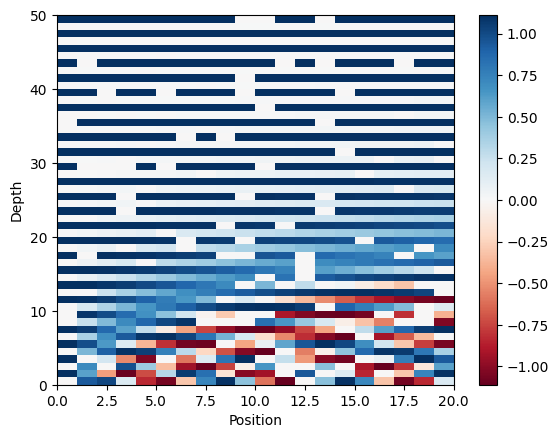

In [12]:
# non learned positional encoding
seq_len = 20
embedding_dim = 50
pos_enc = SinusoidalPositionalEncoder(max_seq_len=seq_len, embedding_dim=embedding_dim, dropout=0.1)
pos_enc.to(device)
pos_enc.positional_encoding()
x = torch.zeros(1, seq_len, embedding_dim, device=device)
pe = pos_enc.forward(x)
np_pe = pe.cpu().detach().numpy()
plt.pcolormesh(np_pe[0].T, cmap="RdBu")
plt.xlabel("Position")
plt.ylabel("Depth")
plt.colorbar()
plt.show()

### Rotary position embedding
https://medium.com/ai-insights-cobet/rotary-positional-embeddings-a-detailed-look-and-comprehensive-understanding-4ff66a874d83

In [13]:
# | hide
import nbdev

nbdev.nbdev_export("./pos_encoding.ipynb")